## Packages

In [1]:
import os.path as osp
from pathlib import Path
from time import time
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import clear_output

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

## Arguments

In [3]:
bert_model = "bert-base-uncased"
pretrained_model = (
    "../models/bert_pretrained/"  # Expects the pre-trained weights to exist
)
transcripts_path = "../outputs/all_transcripts.csv"
device = "cpu"

## User-Defined Functions

In [4]:
class GrandStand_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, info):
        self.encodings = encodings
        self.labels = labels
        self.info = info

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["info"] = self.info[idx]
        return item

    def __len__(self):
        return len(self.labels)

## Load Transcript

In [5]:
transcripts = pd.read_csv(transcripts_path)
transcripts.sample(n=5)

,file,line,start,end,speaker,speaker_role,word_count,duration,text,year
218,12-1038,219,3489.301,3495.407,Elena_Kagan,scotus_justice,16,6.106,"Was the litigation essentially like this one, ...",12
384,12-515,154,1744.627,1749.279,John_G_Roberts_Jr,scotus_justice,15,4.652,"You as a tribe, you as a tribe would have no o...",12
497,12-682,71,1682.047,1691.018,Anthony_M_Kennedy,scotus_justice,27,8.971,"Well, there are two things. Number one is it d...",12
196,12-1038,175,2822.735,2850.850,John_G_Roberts_Jr,scotus_justice,73,28.115,I thought you just answered the question from ...,12
180,12-1038,143,2319.361,2405.967,Stephen_G_Breyer,scotus_justice,246,86.606,"Oh, that's what I don't understand. Let me pre...",12


In [6]:
print("# Cases:", transcripts["file"].nunique())
print("# Speech Segments:", transcripts.shape[0])

# Cases: 5
# Speech Segments: 565


In [7]:
text = transcripts["text"].tolist()
metadata = transcripts.apply(lambda x: (x["file"], x["line"]), axis=1).tolist()
fake_labels = [0 for i in range(transcripts.shape[0])]

## Load BERT Pre-Trained Weights

In [8]:
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [9]:
st = time()

scotus_encoder = tokenizer(text, truncation=True, padding=True)
scotus_dataset = GrandStand_Dataset(scotus_encoder, fake_labels, metadata)

print(f"{round(time() - st, 2)}s")

0.47s


In [10]:
st = time()
model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=1)

model.load_state_dict(torch.load(f"{pretrained_model}BERTforGS"))
model.eval()
model.to(device)

print(f"{round(time() - st, 2)}s")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

3.09s


## Generate Scores

In [11]:
st = time()

inputs = []
grandstanding_scores = []
for i, batch in enumerate(scotus_dataset):
    clear_output(wait=True)
    print("Item", i)
    print(f"Elapsed Time: {round(time() - st, 2)}s")
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        file_info = batch["info"]
        outputs = model(
            input_ids.reshape(1, -1), attention_mask=attention_mask.reshape(1, -1)
        )
        score = outputs.logits[0].item()
        grandstanding_scores.append((file_info, score))

print(f"Total Time: {round(time() - st, 2)}s")

Item 564
Elapsed Time: 542.99s
Total Time: 543.91s


In [12]:
gs_df = pd.DataFrame(
    data=[(i[0], i[1], s) for (i, s) in grandstanding_scores],
    columns=["file", "line", "gs_score"],
)
gs_df.sample(n=5)

,file,line,gs_score
473,12-682,23,-0.472322
34,12-1036,68,-1.482435
317,12-515,23,-0.047869
190,12-1038,163,-0.232994
60,12-1036,120,0.012528


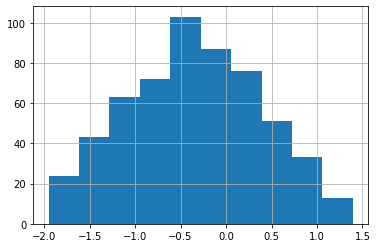

In [13]:
_ = gs_df["gs_score"].hist()

In [14]:
gs_df.to_csv("../outputs/bert_scores.csv")